## Nearby Sanitation complaints in the neighborhood via 311 service requests

In [10]:
#important libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
sns.set(rc={'figure.figsize':(12, 6),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="darkgrid")

In [11]:
garbage_prior_july18 = pd.read_json(
    '../data/raw/garbagedata_prior_to_july2018.json',
    convert_dates=['completion_date', 'creation_date'])
sanitation_prior_july18 = pd.read_json(
    '../data/raw/sanitationdata_prior_to_july2018.json',
    convert_dates=['completion_date', 'creation_date'])
rodent_prior_july18 = pd.read_json(
    '../data/raw/rodentdata_prior_to_july2018.json',
    convert_dates=['completion_date', 'creation_date'])
#combining them all 
service_prior_july18 = pd.concat(
    [garbage_prior_july18, sanitation_prior_july18, rodent_prior_july18],
    ignore_index=True)

In [12]:
service_prior_july18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171570 entries, 0 to 171569
Data columns (total 23 columns):
community_area                                171569 non-null float64
completion_date                               171475 non-null datetime64[ns]
creation_date                                 171570 non-null datetime64[ns]
current_activity                              122963 non-null object
latitude                                      171545 non-null float64
location                                      171545 non-null object
longitude                                     171545 non-null float64
most_recent_action                            122863 non-null object
number_of_black_carts_delivered               59300 non-null float64
number_of_premises_baited                     63961 non-null float64
number_of_premises_with_garbage               64034 non-null float64
number_of_premises_with_rats                  64103 non-null float64
police_district                           

In [13]:
###Take only relevant columns
service_prior_july18 = service_prior_july18[[
    'creation_date', 'latitude', 'longitude', 'completion_date',
    'type_of_service_request'
]]
service_prior_july18.sort_values('creation_date', inplace=True)
service_prior_july18.rename(columns={
    'creation_date': 'created_date',
    'completion_date': 'closed_date',
    'type_of_service_request': 'sr_type'
},
                            inplace=True)

In [14]:
service_prior_july18.head()

,created_date,latitude,longitude,closed_date,sr_type
59440,2017-01-02,41.855265,-87.715250,2017-04-04,Garbage Cart Black Maintenance/Replacement
166051,2017-01-02,41.789780,-87.669330,2017-01-04,Rodent Baiting/Rat Complaint
143893,2017-01-02,41.777431,-87.795033,2017-01-03,Rodent Baiting/Rat Complaint
90143,2017-01-02,41.905160,-87.706864,2017-01-04,Sanitation Code Violation
61920,2017-01-02,41.795555,-87.670555,2017-04-17,Garbage Cart Black Maintenance/Replacement


In [15]:
service_data = pd.read_json(
    '../data/raw/servicedata.json',
    convert_dates=['closed_date', 'created_date', 'last_modified_date'])
service_data.head(3)

,city,closed_date,community_area,created_date,created_day_of_week,created_hour,created_month,duplicate,electrical_district,electricity_grid,...,status,street_address,street_direction,street_name,street_number,street_type,ward,x_coordinate,y_coordinate,zip_code
0,None,2019-06-17 07:08:53,NaN,2019-03-13 14:10:42,4,14,3,False,NaN,None,...,Completed,1510 S Lincoln ST,S,Lincoln,1510,ST,NaN,NaN,NaN,60064
1,None,NaT,NaN,2019-03-30 12:26:14,7,12,3,False,NaN,None,...,Open,12500 S NORMAL AVE,S,NORMAL,12500,AVE,NaN,NaN,NaN,None
10,None,2019-06-25 04:43:04,NaN,2019-03-21 11:39:21,5,11,3,False,NaN,None,...,Completed,9001 W 87 ST,W,87,9001,ST,NaN,NaN,NaN,60620


In [16]:
service_data['sr_type'].value_counts()

Garbage Cart Maintenance             48844
Rodent Baiting/Rat Complaint         42423
Sanitation Code Violation            15909
Sewer Cleaning Inspection Request    15802
Name: sr_type, dtype: int64

In [17]:
service_data['sr_type'].value_counts()

Garbage Cart Maintenance             48844
Rodent Baiting/Rat Complaint         42423
Sanitation Code Violation            15909
Sewer Cleaning Inspection Request    15802
Name: sr_type, dtype: int64

In [18]:
service_data = service_data[service_data['sr_short_code'] != 'CHECKFOR']
service_data = service_data[[
    'created_date', 'latitude', 'longitude', 'closed_date', 'sr_type',
    'duplicate'
]]
service_data = pd.concat([service_data, service_prior_july18],
                         ignore_index=True)
sr_type_map = {
    "sr_type": {
        "Garbage Cart Black Maintenance/Replacement":
        "Garbage Cart Maintenance"
    }
}
service_data.replace(sr_type_map, inplace=True)
shape = service_data.shape
print(" So there are %d rows and %d columns in the data" %
      (shape[0], shape[1]))

 So there are 278746 rows and 6 columns in the data


In [19]:
print(service_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278746 entries, 0 to 278745
Data columns (total 6 columns):
closed_date     274884 non-null datetime64[ns]
created_date    278746 non-null datetime64[ns]
duplicate       107176 non-null object
latitude        278401 non-null float64
longitude       278401 non-null float64
sr_type         278746 non-null object
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 12.8+ MB
None


I now want to count number of these incidents around the business and within some prespecified time. We can optimize the distance and the time windows but for the first pass study, I am just foucsing on within 5 miles radii and the 7 days before the inspection date. 

In [20]:
service_data['latitude'].fillna(service_data['latitude'].mode()[0],
                                inplace=True)
service_data['longitude'].fillna(service_data['longitude'].mode()[0],
                                 inplace=True)
service_data = service_data[service_data['duplicate'] != True]
print(service_data.sr_type.value_counts())

Garbage Cart Maintenance        120745
Rodent Baiting/Rat Complaint    107575
Sanitation Code Violation        44214
Name: sr_type, dtype: int64


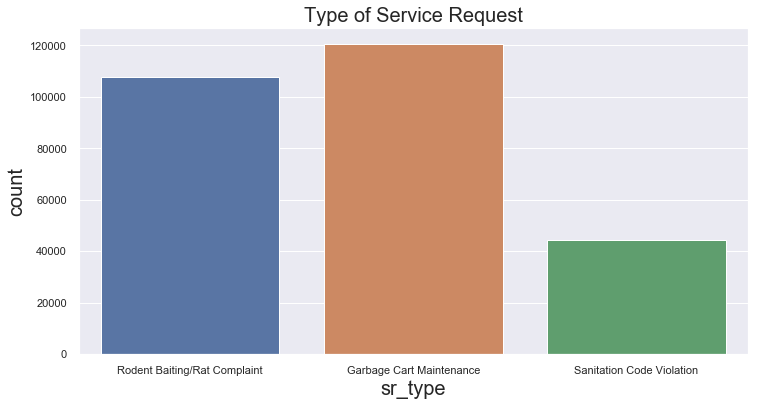

In [21]:
ax = sns.countplot(x='sr_type', data=service_data)
plt.title("Type of Service Request")
plt.show()

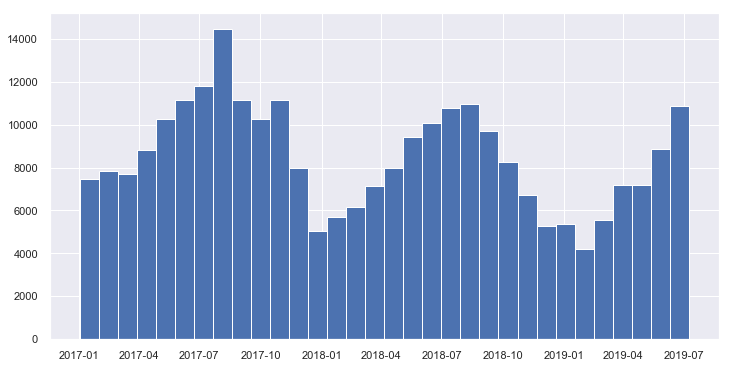

In [23]:
service_data["sr_type"] = service_data["sr_type"].astype('category').cat.codes
service_data['created_date'].hist(bins = 32)

In [24]:
service_data.sort_values(by='created_date', inplace=True)
service_data = service_data[['created_date','latitude', 'longitude']]

In [27]:
service_data.to_csv('../data/processed/service_request_data_processed.csv')